In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The Plan

* Explore and visualize a dataset 
* Use K-nearest-neighbors for density estimation on 2D slices of data
* Use K-nearest-neighbors for density estimation on 4D data

## The Data

The fisher iris data is hosted online by [UC Irvine](http://archive.ics.uci.edu/ml/datasets/Iris). I prefer to download a local copy and use that, so in the next cell we check if the data exists locally and then download it if neaded. 

In [6]:
IRIS_DATA_PATH = 'bezdekIris.data'
IRIS_DATA_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data'

In [7]:
import os
from urllib2 import urlopen

if not os.path.isfile(IRIS_DATA_PATH):
    file(IRIS_DATA_PATH, 'w').write(urlopen(IRIS_DATA_URL).read())

The dataset is stored using 'comma-separated values' (CSV). This data format is comonly used for design matrices because it can be easily read and edited by humans and machines. In fact you can open this file in most spreadsheet sofware. 

Let's look at the data. I will use [pandas](http://pandas.pydata.org/) to read and display the CSV file. 
> **NOTE:** Many people swear by pandas, but I myself use it only occationally. You should feel free to explore it and let me know if I am missing out on suful features. I am using pandas now because it displays tables nicely in jupyter and it sniffs out the datatype of each column. Python has other libraries for parsin CSV as well.

In [16]:
import pandas
df = pandas.read_csv(IRIS_DATA_PATH, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'species'])
df

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


Let's use the terminology of the book; the last column is the thing we want to predict (the flower species). The remaining cllumns are the data.

In [26]:
targets = df.loc[:, 'species'].as_matrix()
data = df.loc[:,'sepal length':'petal width'].as_matrix()

It is imporant at this point to remember that one should not draw any conclusions on whther their classifier works based on the data that you use to fit your model (i.e. for training). 

In this notebook I will, for now, use the entire dataset. **However**, after exploring in a notebook like this you should create a single function or class that doeas the learning, and invoke it on subsets of the data. 

Let's do some 2D plots of the data, but first I need to remind myself of the class names...

In [35]:
print unique(targets)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


I am going to create a boolean mask for each class. In the first three lines below, the `==` operator does the comparison for each array element and returns an array of boleans. I can pass the array in just like it was an index in order to filter out rows of data for plotting. 

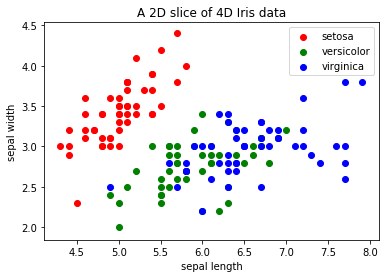

In [45]:
setosa = target=='Iris-setosa'
versicolor = target=='Iris-versicolor'
virginica = target=='Iris-virginica'

scatter(data[setosa,0], data[setosa,1], color='red', label='setosa');
scatter(data[versicolor,0], data[versicolor,1], color='green', label='versicolor');
scatter(data[virginica,0], data[virginica,1], color='blue', label='virginica');
xlabel(df.columns[0])
ylabel(df.columns[1])
legend(loc='upper right')
title('A 2D slice of 4D Iris data');

In the plot above, I used `label=` to assign labels to the scatter plots of each class. The labels are used by the `legend()` function to put a legend inthe plot. 

Note that this was only a single slice of the data; there are $M^2$  different combinations of $x$ and $y$ axises (if $M$ is the number of columns of data).

It is often useful to view the whole array of plots (even though almost half of them are redundant). In the cell below, I show a scatter plot for each pair of features. Along the diagonals (where the x and y axises would be the same), I instead plot histograms.

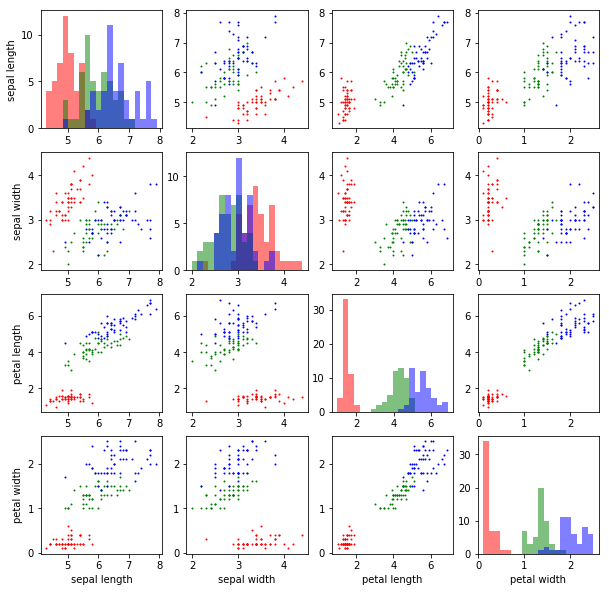

In [67]:
fig, axes = subplots(4, 4)
fig.set_size_inches(10,10)
for i in range(4):
    axes[-1, i].set_xlabel(df.columns[i])
    axes[i,  0].set_ylabel(df.columns[i])

for row in range(4):
    for col in range(4):
        sca(axes[row, col]) # Send all plotting instructions to the current subplot
        if row == col:
            vmin=data[:,col].min()
            vmax=data[:,col].max()
            hist(data[setosa,col], bins=20, range=(vmin,vmax), color='red', histtype='stepfilled', alpha=0.5)
            hist(data[versicolor,col], bins=20, range=(vmin,vmax), color='green', histtype='stepfilled', alpha=0.5)
            hist(data[virginica,col], bins=20, range=(vmin,vmax), color='blue', histtype='stepfilled', alpha=0.5)
        else:
            scatter(data[setosa,col], data[setosa,row], color='red', s=1, label='setosa');
            scatter(data[versicolor,col], data[versicolor,row], color='green', s=1, label='versicolor');
            scatter(data[virginica,col], data[virginica,row], color='blue', s=1, label='virginica');

Unfortunately it is hard t wrap our brains around 4D data, but this kind of plot is a useful way to think of things. 

> **NOTE:** There is one kind of error that is _extremely_ annoying -- rounding error. In this case, you can see that the points seem to lie along points in a grid.  It is unlikely that the original data had this pattern, so we might actually produce a set sample that is _**more**_ true to the underlying model for flowers by adding a small perturbation to the data. 

In [102]:
data += normal(scale=0.05, size=data.shape)

Now notice that the quantization "noise" has been replaced by the gaussian 'jitter' we applied to the data. 

Nother huge benefit is that it is no longer as likely that two points occupy the exact same location. This helps with some numerical algorithms one might apply to the data as well as making the visualization more plausible. 

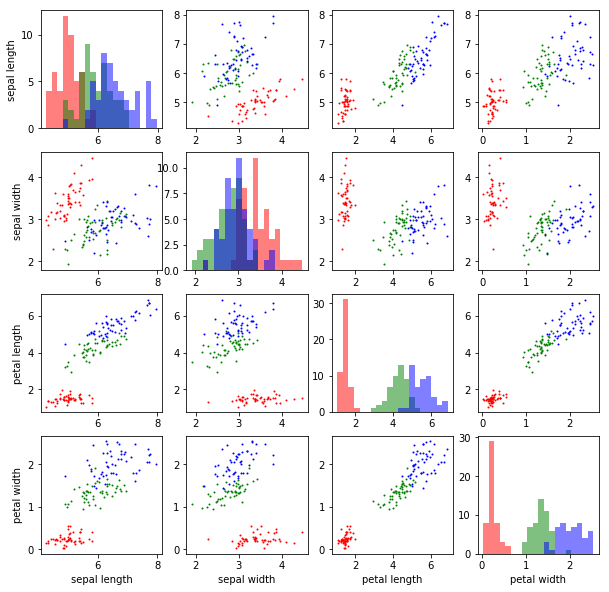

In [104]:
fig, axes = subplots(4, 4)
fig.set_size_inches(10,10)
for i in range(4):
    axes[-1, i].set_xlabel(df.columns[i])
    axes[i,  0].set_ylabel(df.columns[i])

for row in range(4):
    for col in range(4):
        sca(axes[row, col]) # Send all plotting instructions to the current subplot
        if row == col:
            vmin=data[:,col].min()
            vmax=data[:,col].max()
            hist(data[setosa,col], bins=20, range=(vmin,vmax), color='red', histtype='stepfilled', alpha=0.5)
            hist(data[versicolor,col], bins=20, range=(vmin,vmax), color='green', histtype='stepfilled', alpha=0.5)
            hist(data[virginica,col], bins=20, range=(vmin,vmax), color='blue', histtype='stepfilled', alpha=0.5)
        else:
            scatter(data[setosa,col], data[setosa,row], color='red', s=1, label='setosa');
            scatter(data[versicolor,col], data[versicolor,row], color='green', s=1, label='versicolor');
            scatter(data[virginica,col], data[virginica,row], color='blue', s=1, label='virginica');

# Density Estimation using K-NN
The K-Nearest Neighbor (KNN)  approach is a nonparametric way to estimate a (pseudo) probability density function. 
We will use it to estimate the probability of seing a sample given some attributes.

One could write a for-loop to search for the nearest neighbors of any point, and for high-dimensional data that is about as good as we can get, assymptotically. However, we usually build some sort of spatial index data structure (e.g. a **tree**) for several reasons:
* Sometimes the data is low dimensional, or we can reduce the dimensionality using some transformation. For low dimensional datset KD-trees or similar data structures work well.
* Sometimes we can accept an _**approximate**_ nearest neighbor search, in which case efficient data structures can be fit to our data to make searching fast even for high dimensional data.

The next cell uses the nearest neighbor data structure that ships with `sklearn`, however you will find some others online that specialize on huge out of core data, or date that needs to be updated frequently, etc. 

In [105]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=4)

For now, let's use a 2D subset of our data. We will pluck out columns 0 ('sepal length') and 2 ('petal length'). 

In [106]:
x = data[:, (0, 2)]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, targets)

In [107]:
print "training data shape:", x_train.shape
print "test data shape:", x_test.shape

training data shape: (112, 2)
test data shape: (38, 2)


In [108]:
nn.fit(x_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=4, p=2, radius=1.0)

The `kneighbors` method takes in an array of $n$ samples and returns two arrays; 
* An $n\times k$ array that has the distance to each of the $k$ nearest points to each sample
* An  $n\times k$ array that has the indexes of the training samples for the $k$ nearest points. 

In [112]:
dist, ind = nn.kneighbors(atleast_2d(x_test))
print dist

[[ 0.17054808  0.29014022  0.37496734  0.41406263]
 [ 0.08656545  0.15754475  0.16333329  0.19022876]
 [ 0.13168724  0.16668076  0.19780757  0.21472365]
 [ 0.07393281  0.15235828  0.16870612  0.20113779]
 [ 0.09912598  0.33718435  0.353788    0.39645376]
 [ 0.037591    0.06863311  0.0913795   0.13485027]
 [ 0.28868312  0.29927859  0.31142227  0.32328696]
 [ 0.16057163  0.20102329  0.22666583  0.28877815]
 [ 0.16539861  0.18903813  0.31155379  0.36294283]
 [ 0.09600882  0.18737617  0.21784645  0.24360462]
 [ 0.14068833  0.23520442  0.27391872  0.31653931]
 [ 0.08632458  0.23427365  0.32035015  0.33802195]
 [ 0.10836431  0.12971857  0.18071148  0.22107811]
 [ 0.07982131  0.08224246  0.09543022  0.12252616]
 [ 0.03516456  0.0921432   0.1256957   0.13475715]
 [ 0.15778065  0.16940961  0.18365489  0.20518662]
 [ 0.10310769  0.15828719  0.18909596  0.24831745]
 [ 0.15248749  0.1897488   0.23527891  0.33475098]
 [ 0.01394528  0.2083268   0.28858638  0.2892971 ]
 [ 0.00901467  0.07142258  0.18

In order to make sure we understand the data, let's visualize it. 

In the next cell I use scatter plots to show the training and test data points. 
Then I go through each test sample and add a line to the $k$ nearest training samples. 

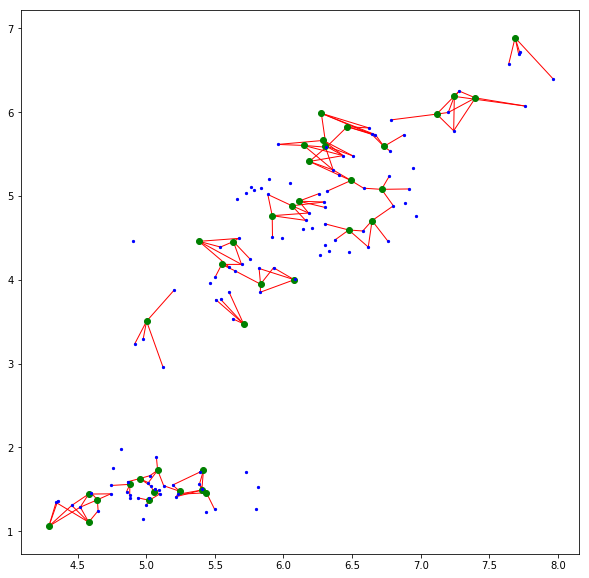

In [117]:
figsize(10,10)
scatter(x_train[:,0], x_train[:,1], color='blue', s=5, zorder=2)
scatter(x_test[:,0], x_test[:,1], color='green', zorder=1)
ax = gca()
for j in range(len(x_test)):
    for i in ind[j]:
        ax.add_line(Line2D([x_test[j,0], x_train[i,0]], 
                           [x_test[j,1], x_train[i,1]], 
                           color='red', 
                           linewidth=1, zorder=0))

> **TODO:** Evaluate $p(\mathbf{x})$ and $p(\mathbf{x}|t)$